<a href="https://colab.research.google.com/github/romulokps/apoiasus/blob/master/PCRcidades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

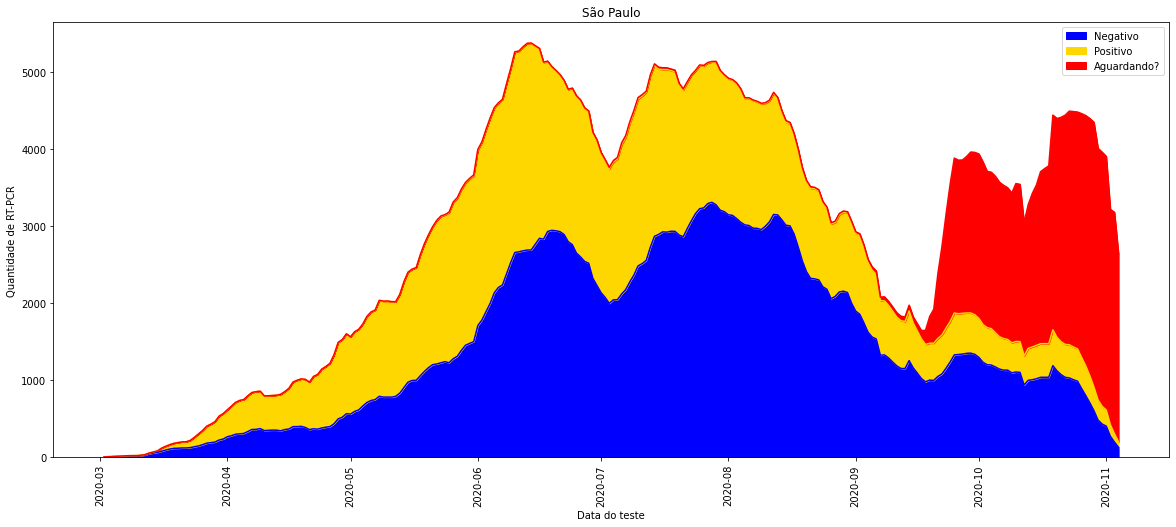

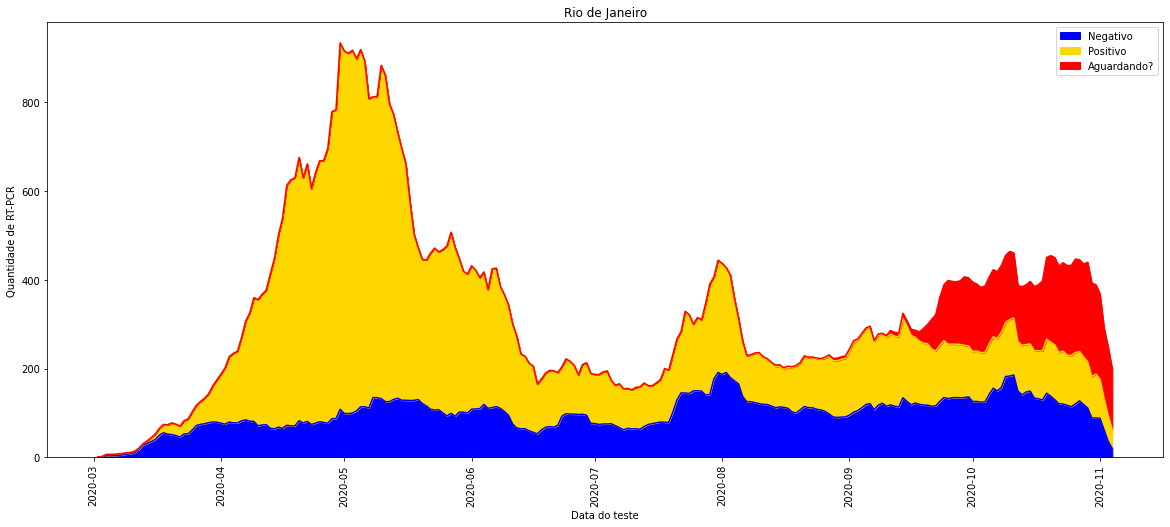

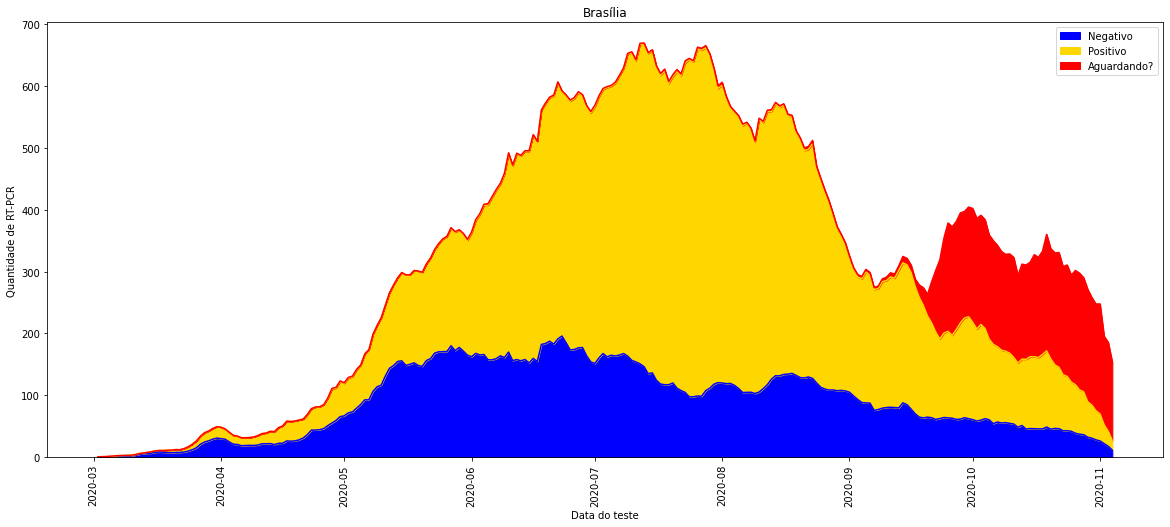

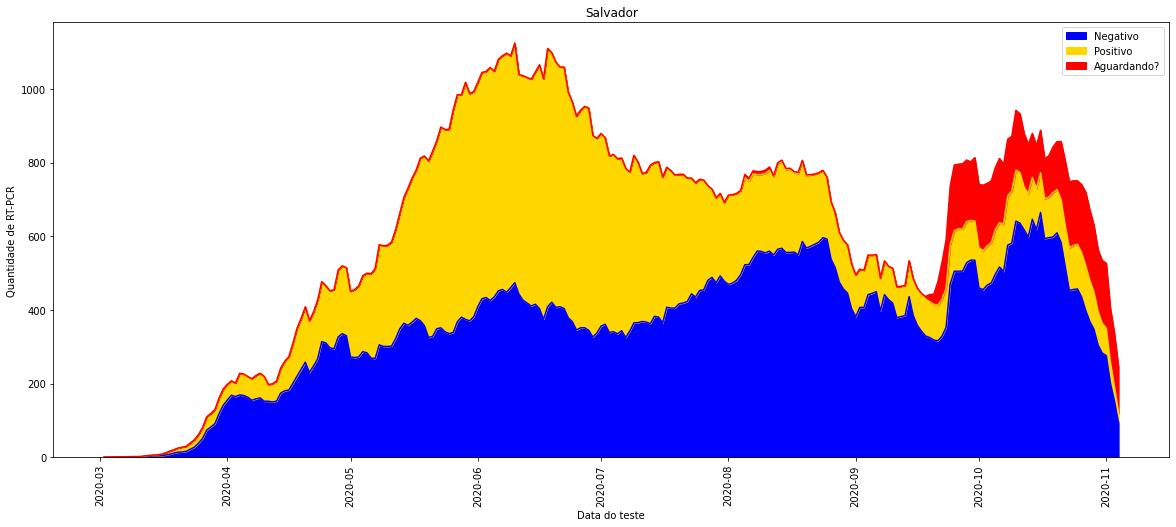

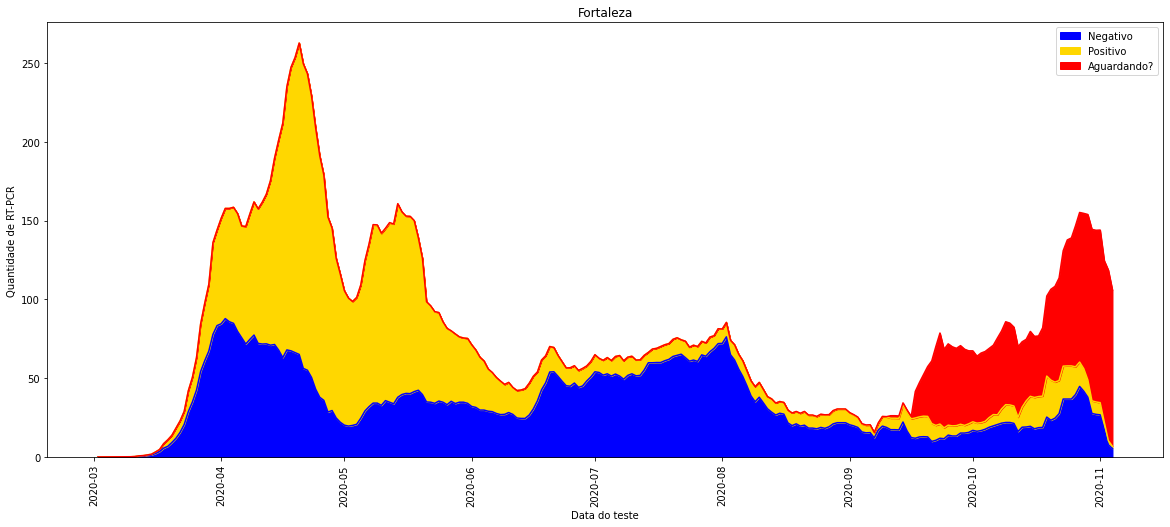

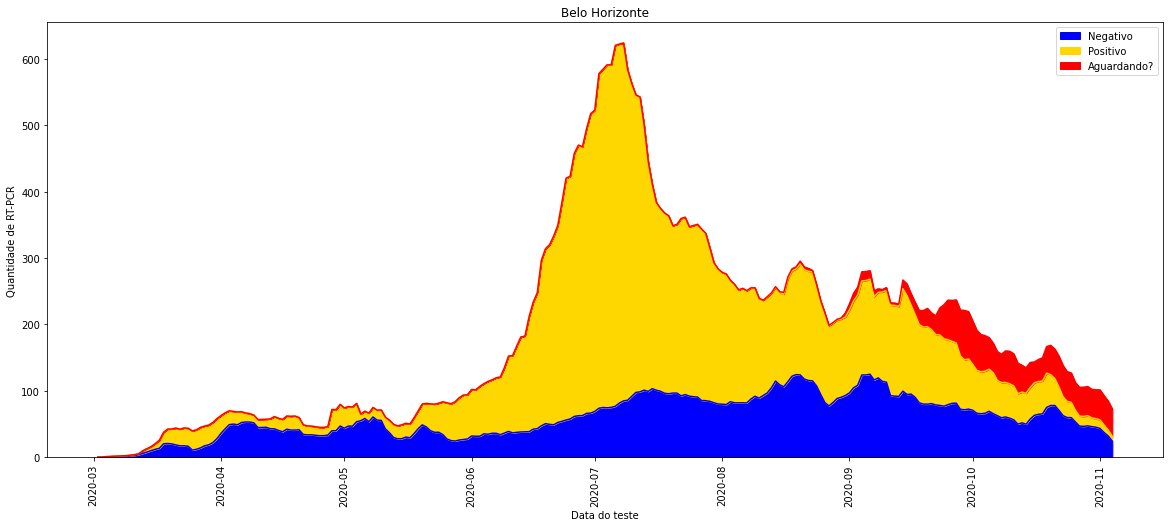

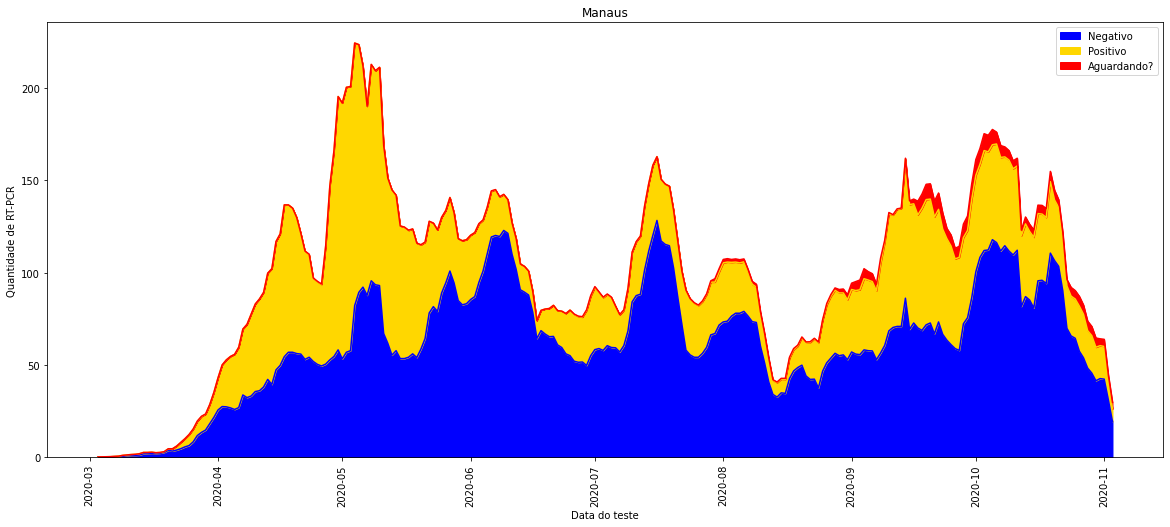

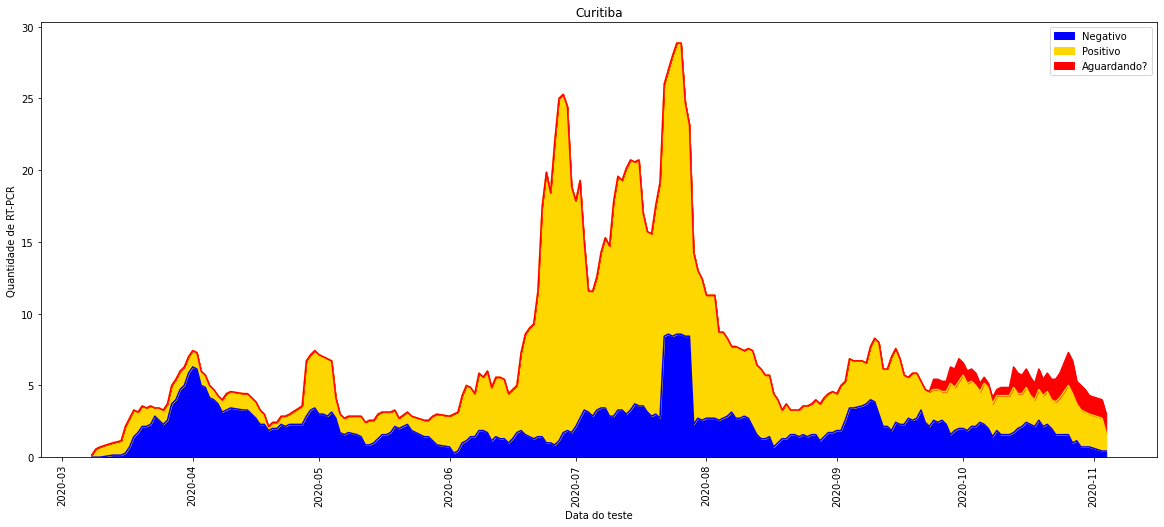

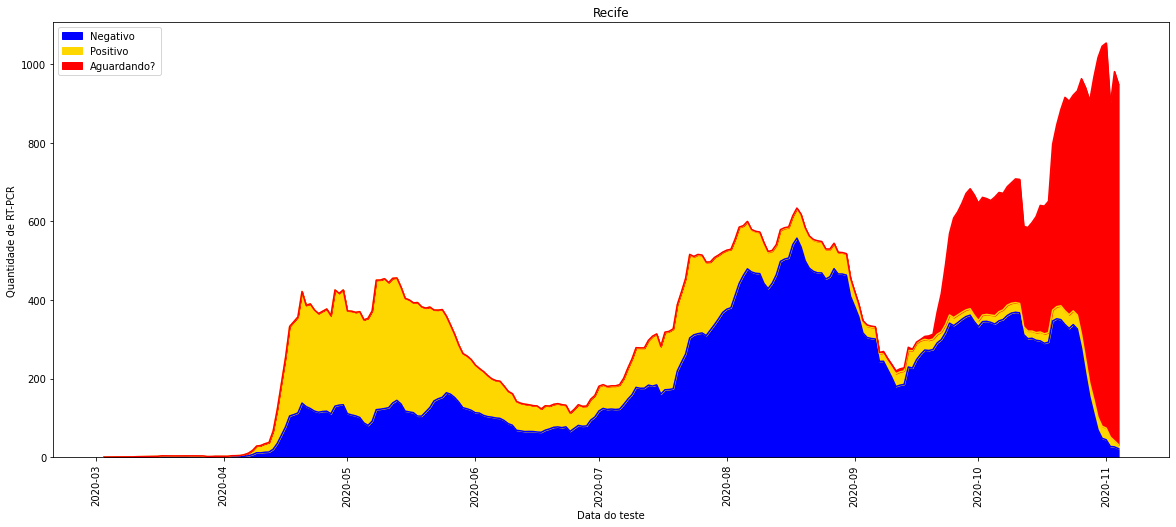

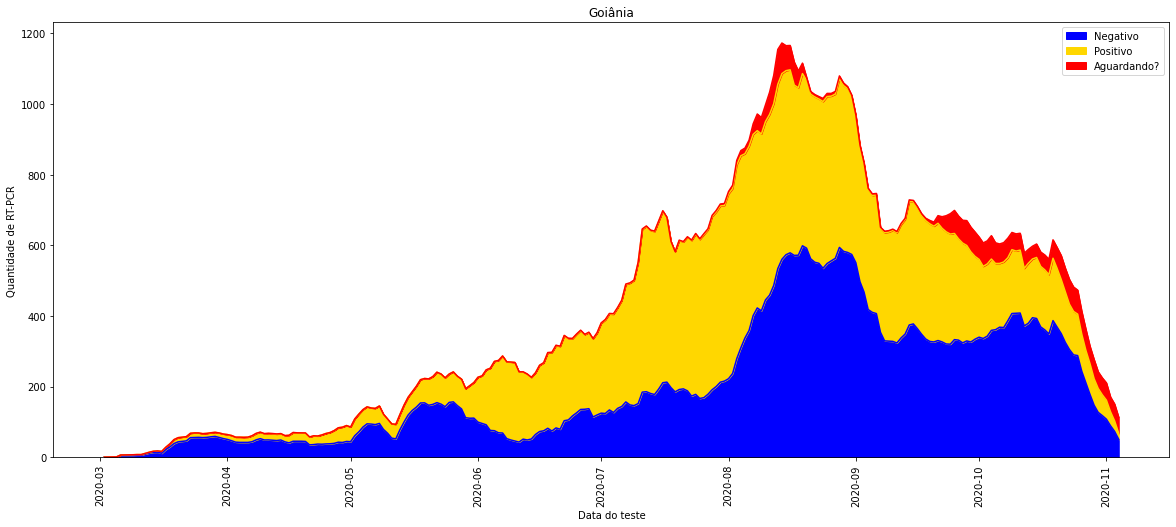

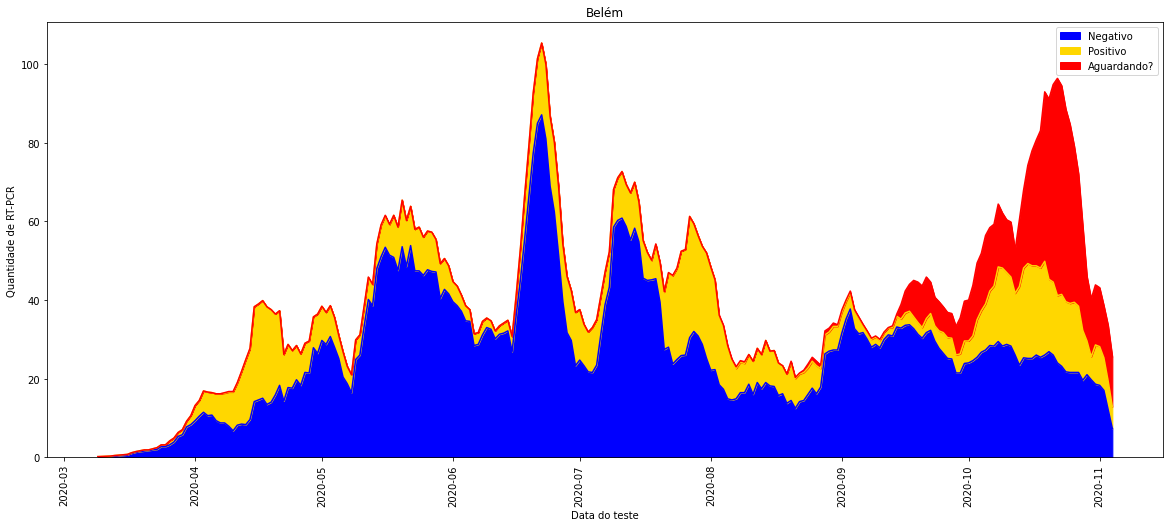

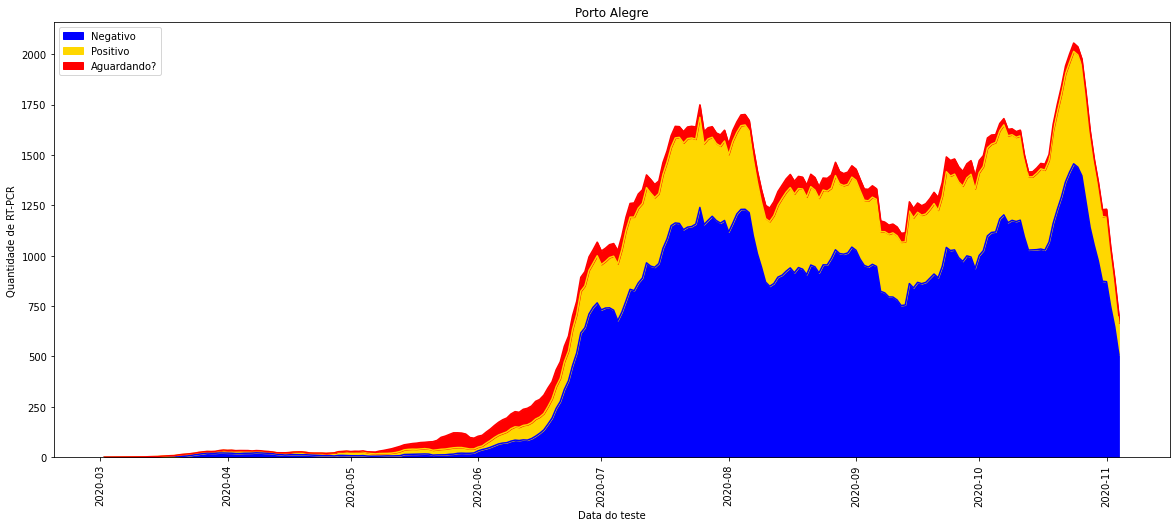

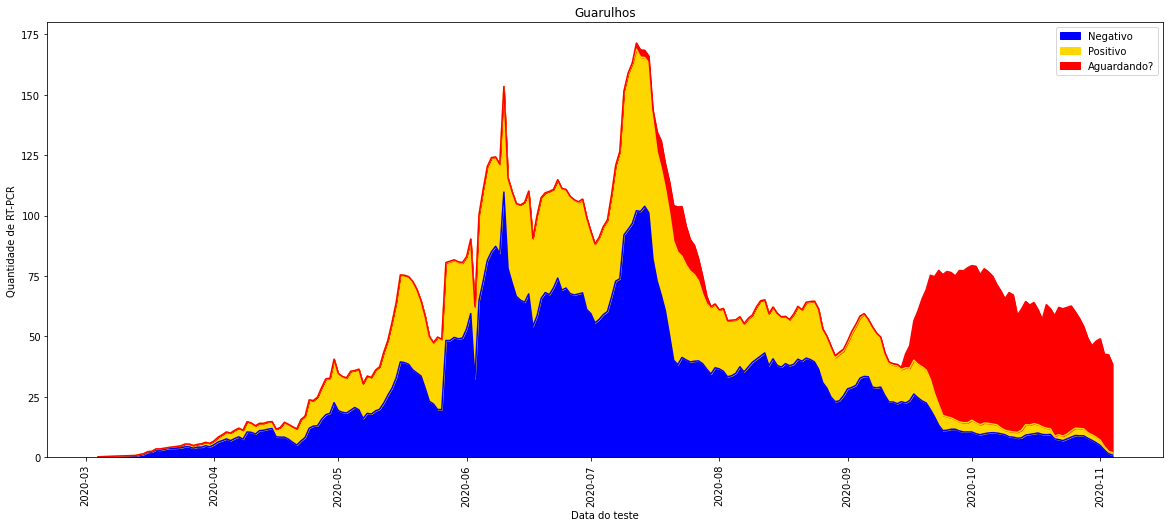

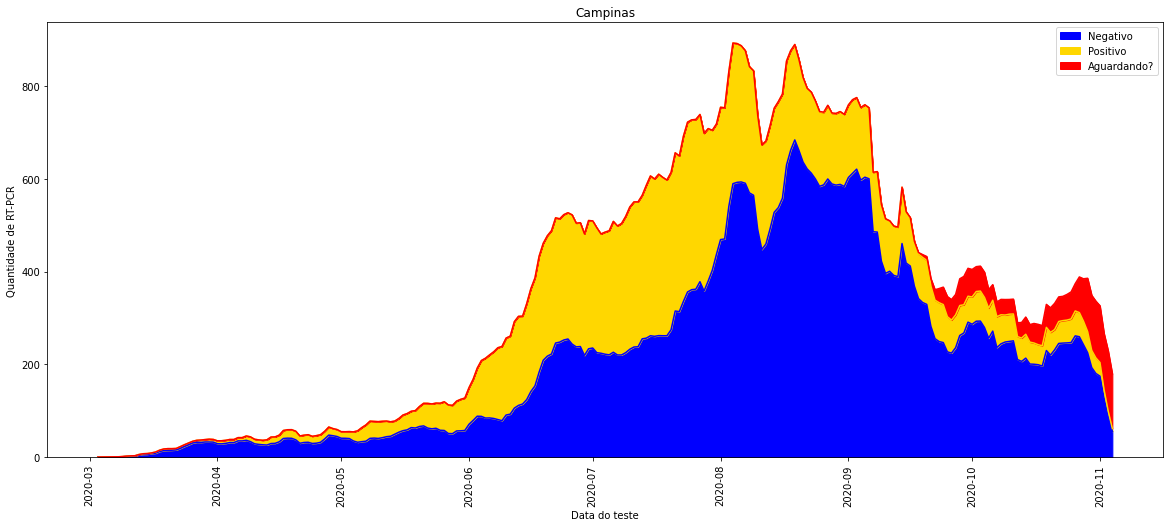

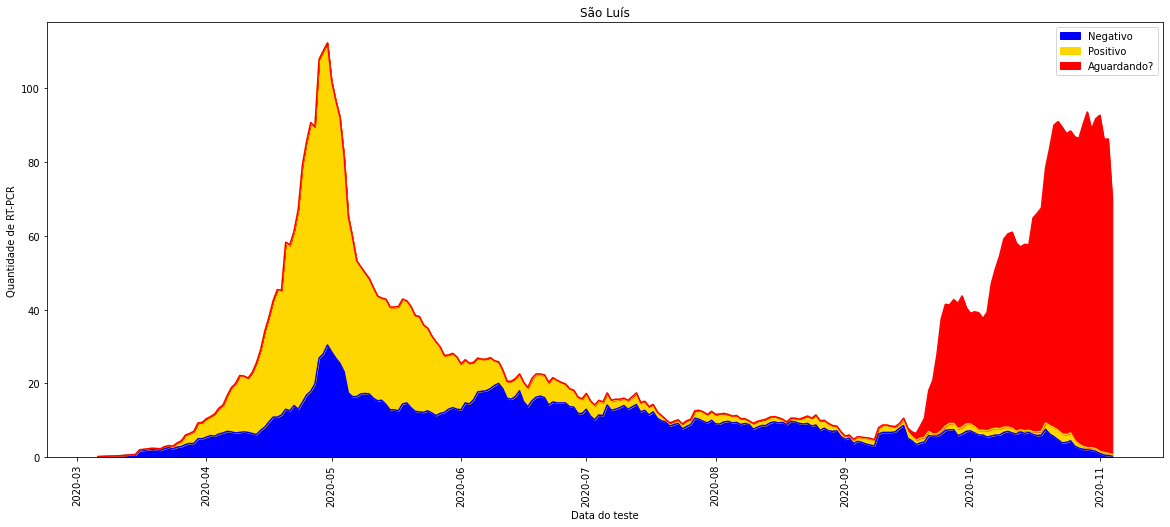

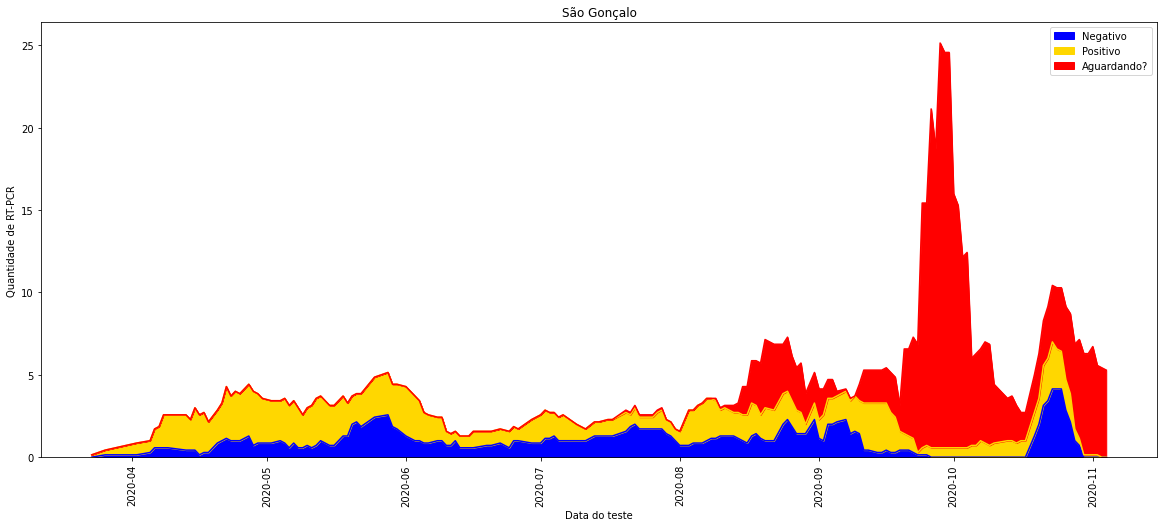

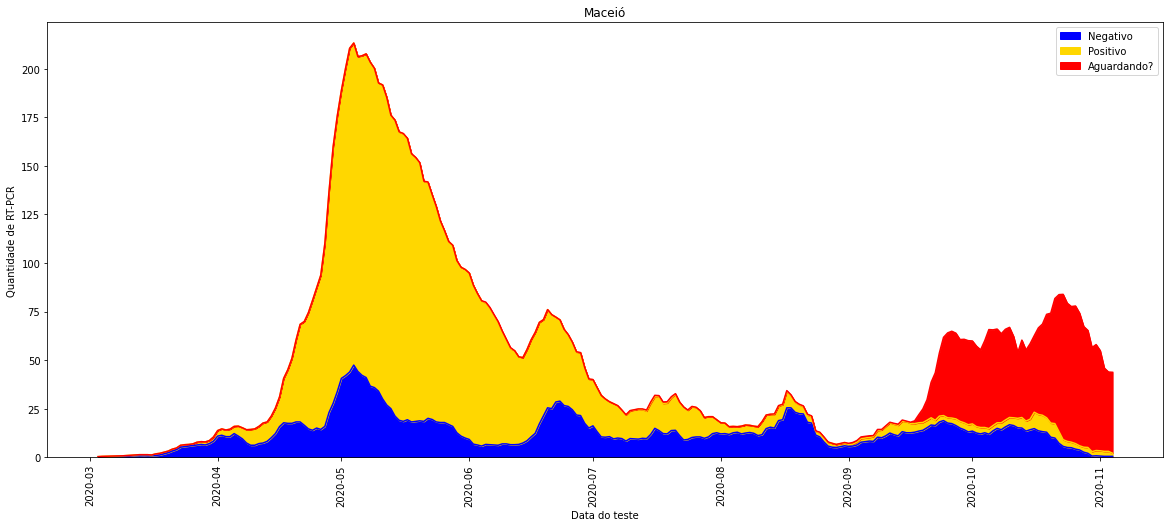

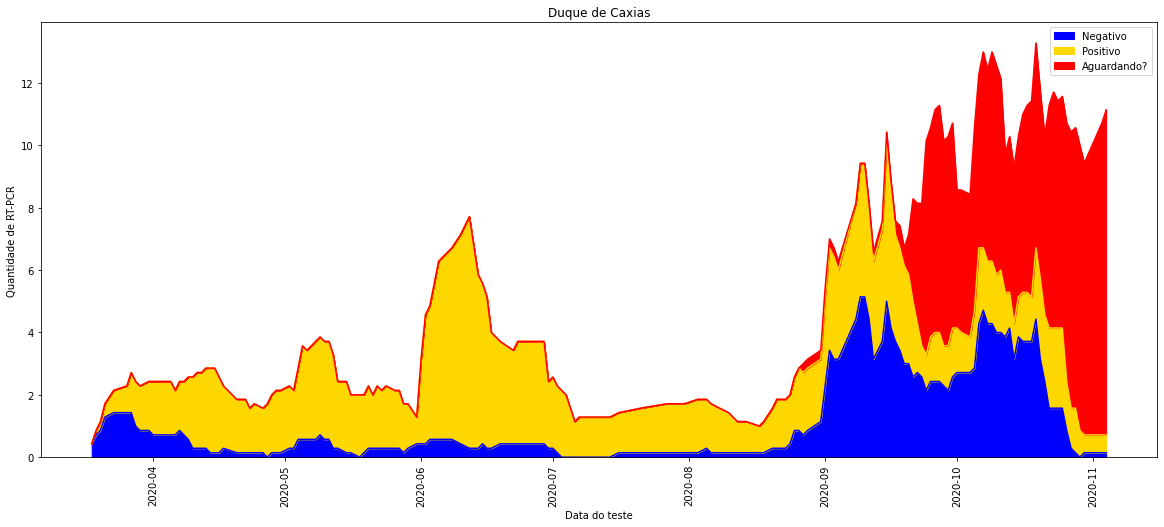

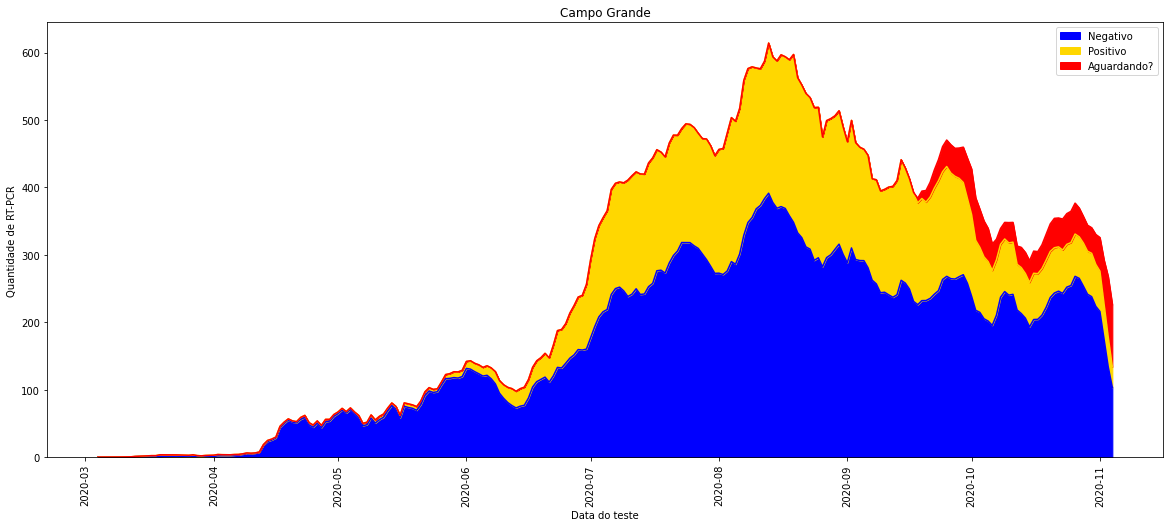

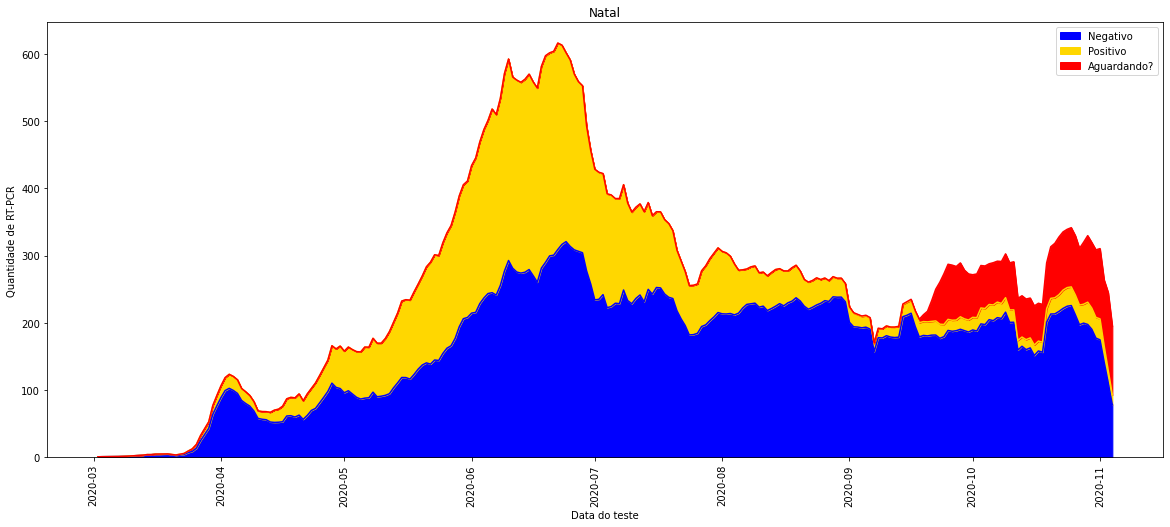

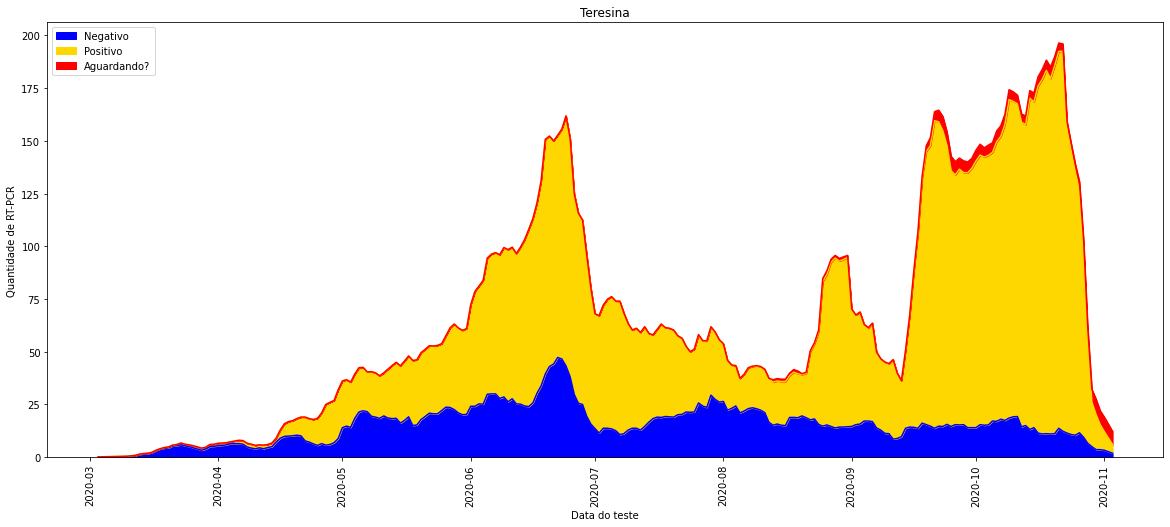

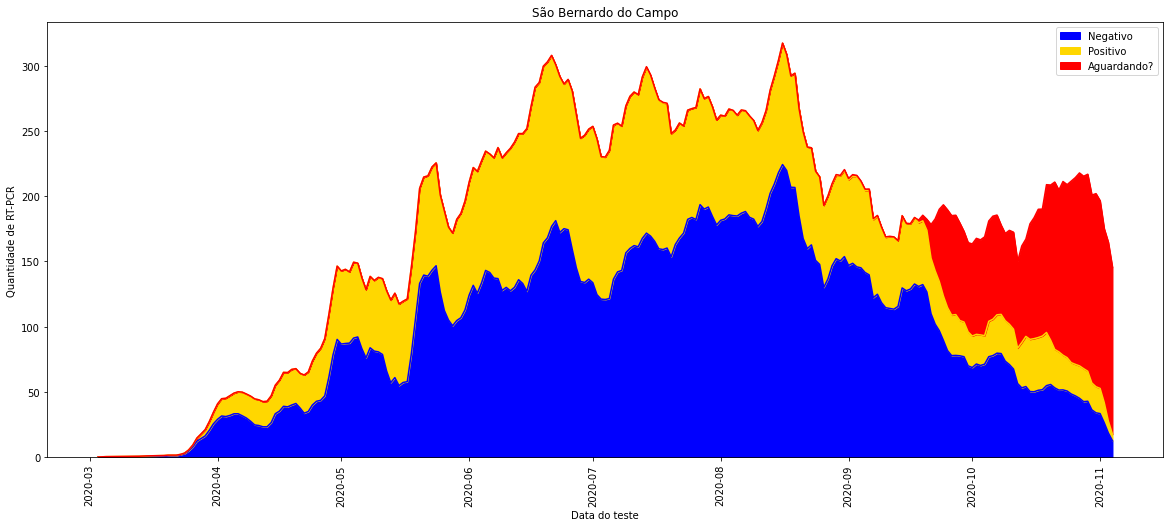

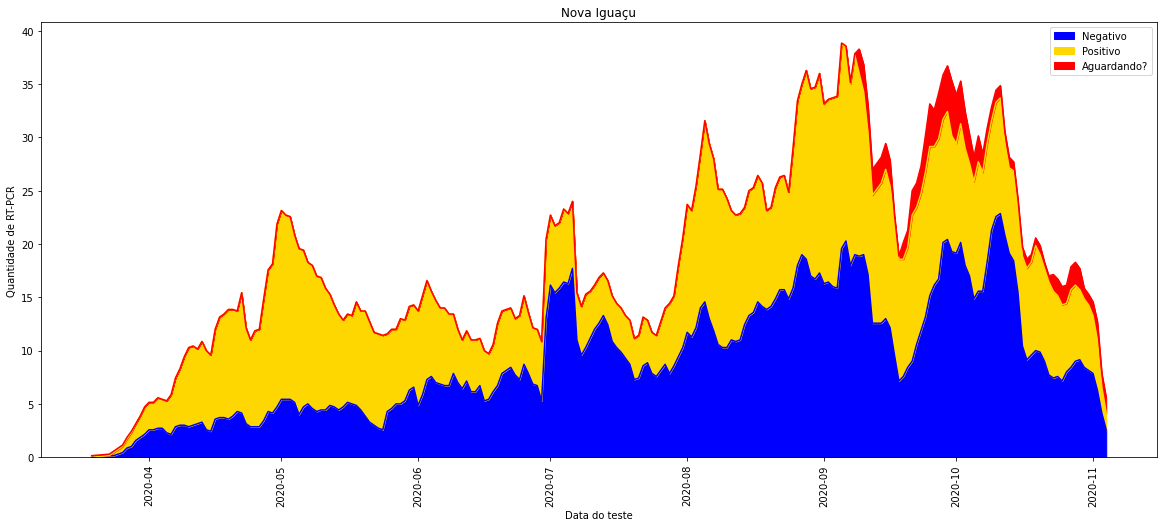

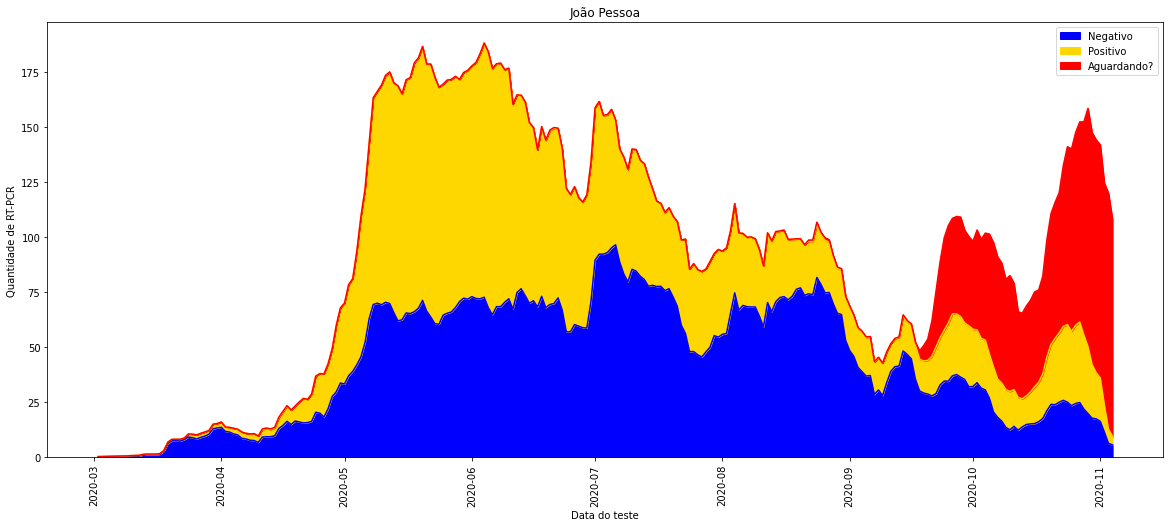

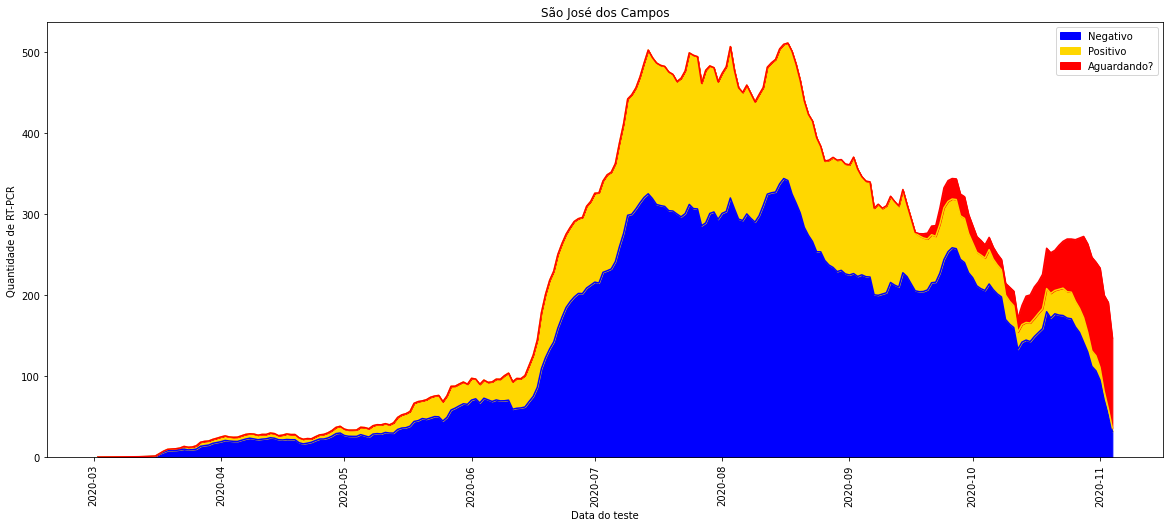

In [4]:
import pandas as pd
import csv
from datetime import datetime
from scipy import stats
import numpy as np

caminho = '/content/drive/My Drive/dados/'
pop = pd.read_csv('https://raw.githubusercontent.com/romulokps/testesPCR/main/populacaoBR.csv')
pop = pop.sort_values(by = 'pop', ascending=False).head(25)
#pop = pop.sort_values(by = 'pop', ascending=False).tail(2)
#pop = pop.sort_values(by = 'pop', ascending=False).head(1)
pop = pop.reset_index()

for i in pop.index:
    fe = pd.read_csv(caminho + pop.iloc[i]['estado'], low_memory = False)
    fe = fe[fe['tipoTeste'] == 'RT-PCR']
    #if (ibge != 0):
    fe = fe[fe['municipioNotificacaoIBGE'] == pop.iloc[i]['ibgeID']]
    estado = pop.iloc[i]['cidade']
    #else:
      #estado = pop.iloc[i]['estadoNome']
    #fe = fe[fe['resultadoTeste'].notnull()]
    fe = fe[fe['resultadoTeste'] != 'Inconclusivo ou Indeterminado']
    fe = fe[['dataTeste', 'resultadoTeste','estado']]
    fe['dataTeste'] = pd.to_datetime(fe['dataTeste']).dt.date
    fe = fe[fe['dataTeste'] > datetime.strptime('2020-03-01', '%Y-%m-%d').date()]
    #fe = fe.sort_values(by= ['dataTeste'], ascending=False)
    fe = fe.replace(np.nan, "nan")
    fe = pd.get_dummies(fe, columns=['resultadoTeste'])
    fe = fe.groupby('dataTeste').sum()

    #tira os outliers
    z_scores = stats.zscore(fe)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 13).all(axis=1)
    fe = fe[filtered_entries]

    #total = (fe['resultadoTeste_Positivo'] + fe['resultadoTeste_Negativo'] +  fe['resultadoTeste_nan'] + fe['resultadoTeste_Inconclusivo ou Indeterminado']) 
    #taxa = (fe['resultadoTeste_Positivo']/total).rolling(min_periods=1, window=janela).sum()/janela
    #taxai = (fe['resultadoTeste_Positivo']/(total - fe['resultadoTeste_nan'])).rolling(min_periods=1, window=janela).sum()/janela
    janela = 7
    fe['resultadoTeste_Positivo'] = fe['resultadoTeste_Positivo'].rolling(min_periods=1, window=janela).sum()/janela
    fe['resultadoTeste_Negativo'] = fe['resultadoTeste_Negativo'].rolling(min_periods=1, window=janela).sum()/janela
    #fe['resultadoTeste_Inconclusivo ou Indeterminado'] = fe['resultadoTeste_Inconclusivo ou Indeterminado'].rolling(min_periods=1, window=janela).sum()/janela
    fe['resultadoTeste_nan'] = fe['resultadoTeste_nan'].rolling(min_periods=1, window=janela).sum()/janela
    fe.columns = ['Negativo','Positivo','Aguardando?']
    pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
    ax = fe.plot.area(rot=90, figsize = (20,8), color = ["blue","gold", "red"])
    ax.set_title(estado)
    ax.set_xlabel("Data do teste")
    ax.set_ylabel("Quantidade de RT-PCR")
    ax.figure.savefig(caminho + "img/"+ estado + '.png')
    
    #taxai.plot(rot=90, secondary_y=True)